# Multi-Modal Mobility Morphobot (M4) with PPO, Vectorized Environment
In this notebook, you will implement a PPO agent with Group24M4-v0 environment.

### 1. Create Vectorized Environment

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import torch
import numpy as np
import time
import os
from datetime import datetime

from parallelEnv import parallelEnv
from model import PolicyNetwork as actor
from model import ValueNetwork as critic
from ppo import ppo_agent
from storage import RolloutStorage
from gym.vector import SyncVectorEnv
from collections import deque
import matplotlib.pyplot as plt
from envs import make_vec_envs
from utils import get_render_func
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import Categorical

# from stable_baselines3.common.env_util import make_vec_env
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

debug = False

print('gym version: ', gym.__version__)
print('torch version: ', torch.__version__)
print('cuda available: ', torch.cuda.is_available())

seed = 0 
gamma=0.99
num_processes=16 
device = torch.device("cpu")
# device = torch.device("cuda:0")
print('device: ', device)

envs = parallelEnv('Group24M4-v0', n=num_processes, seed=seed)

max_steps = envs.max_steps
print('max_steps: ', max_steps)

if debug:
    action = envs.action_space.sample()
    observation = envs.observation_space.sample()
    ac_size = envs.action_space.shape[0]
    ob_size = envs.observation_space.shape[0]

    print("action", action)
    print("observation", observation)
    print("ac_size", ac_size)
    print("ob_size", ob_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Group24M4-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
2024-11-22 15:58:11.520396: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 15:58:11.544727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 15:58:11.862542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


gym version:  0.26.2
torch version:  2.0.0+cu117
cuda available:  True
device:  cpu
max_steps:  1600


### 2. Instantiate Model, Agent and Storage

Initialize the Policy (model PolicyNetwork), PPO Agent and Rollout Storage.

In [2]:
# init the nn
hidden_size_gru = 35
hidden_size_MLP = 64

if debug:
    print("envs.observation_space.shape: ", envs.observation_space.shape[0])
    print("envs.action_space: ", envs.action_space.shape[0])
    
# actor
actor_nn = actor(envs.observation_space.shape[0],hidden_size_gru,hidden_size_MLP, envs.action_space.shape[0])
# critic
critic_nn = critic(envs.observation_space.shape[0], hidden_size_gru,hidden_size_MLP)
    
actor_nn.to(device)
critic_nn.to(device)

agent = ppo_agent(actor=actor_nn,critic=critic_nn, ppo_epoch=16, num_mini_batch=16,lr=0.001, eps=1e-5, max_grad_norm=0.5)

# init the storage used to store the params of nn, state, action, rewards
rollouts = RolloutStorage(num_steps=max_steps, num_processes=num_processes, obs_shape=envs.observation_space.shape, action_space=envs.action_space, recurrent_hidden_state_size=hidden_size_gru)
print('storage situation', rollouts)

obs = envs.reset()
print('type obs: ', type(obs), ', shape obs: ', obs.shape)
obs_t = torch.tensor(obs)
print('type obs_t: ', type(obs_t), ', shape obs_t: ', obs_t.shape)

rollouts.obs[0].copy_(obs_t)
rollouts.to(device)

if debug:
    print('action_log_prob', rollouts.action_log_probs[0])
    print('action',rollouts.actions[0])
    print('obs space', rollouts.obs[0])
    

storage situation <storage.RolloutStorage object at 0x7f68fc6b2c70>
type obs:  <class 'numpy.ndarray'> , shape obs:  (16, 35)
type obs_t:  <class 'torch.Tensor'> , shape obs_t:  torch.Size([16, 35])


### 3.Save model function

In [3]:
def save(model_1,model_2, directory, filename, suffix):
    if not os.path.exists(directory):
        os.makedirs(directory)
    torch.save(model_1.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(model_2.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    
limits = [-300, -160, -100, -70, -50, 0, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf      

### 4. Train the Agent  with Vectorized Environment

In [4]:
num_updates=600
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1

# Define the log directory
log_dir = 'runs/ppo_experiment'

# Get the current time as a string for tagging
current_time_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

def ppo_vec_env_train(envs, agent, actor_nn,critic_nn, num_processes, num_steps, rollouts):

    # Create a new SummaryWriter
    writer = SummaryWriter(log_dir=log_dir)
    
    time_start = time.time()
    
    n=len(envs.ps)
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    indices = []
    for i  in range(n):
        indices.append(i)
     
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        for timestep in range(num_steps):
            
            if debug:
                print(f'{timestep} obs {rollouts.obs[timestep]}')
                print(f'{timestep} recurrent hidden states {rollouts.recurrent_hidden_states[timestep]}')
            
            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   actor_nn.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
            
            if debug:    
                print('action',actions)
                print('the size of action log probs',action_log_prob.size())
                print('action log prob',action_log_prob)
                
            obs, rewards, done, infos = envs.step(actions.cpu().detach().numpy())
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            ## Add one dimnesion to tensor, otherwise does not work
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                    
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = critic_nn.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)

        agent.update(rollouts)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        # TensorBoard Logging
        writer.add_scalar(f'Average Total Reward/{current_time_tag}', avg_total_reward, i_episode)
        writer.add_scalar(f'Average Score/{current_time_tag}', avg_score, i_episode)
        
        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(actor_nn,critic_nn, 'dir_save', 'we0', suf)

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 

    
        if len(scores_deque) == 100 and np.mean(scores_deque) > 400:
            print('Environment solved with Average Score: ',  np.mean(scores_deque) )
            break
    
    writer.close()

    return scores_array, avg_scores_array


In [5]:
scores, avg_scores = ppo_vec_env_train(envs, agent, actor_nn, critic_nn, num_processes, max_steps, rollouts)

/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5418/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/yuku/anaconda3/envs/n5

Number of agents:  16
Ep. 1, Timesteps 1600, Score.Agents: -13832.88, Avg.Score: -13176.21, Time: 00:00:07, Interval: 00:07
Ep. 2, Timesteps 1600, Score.Agents: -14077.78, Avg.Score: -13476.73, Time: 00:00:12, Interval: 00:05
Ep. 3, Timesteps 1600, Score.Agents: -14412.50, Avg.Score: -13710.68, Time: 00:00:17, Interval: 00:05
Ep. 4, Timesteps 1600, Score.Agents: -13867.46, Avg.Score: -13742.03, Time: 00:00:21, Interval: 00:04
Ep. 5, Timesteps 1600, Score.Agents: -14839.66, Avg.Score: -13924.97, Time: 00:00:26, Interval: 00:05
Ep. 6, Timesteps 1600, Score.Agents: -15425.81, Avg.Score: -14139.38, Time: 00:00:30, Interval: 00:04
Ep. 7, Timesteps 1600, Score.Agents: -13659.29, Avg.Score: -14079.37, Time: 00:00:34, Interval: 00:04
Ep. 8, Timesteps 1600, Score.Agents: -13068.94, Avg.Score: -13967.10, Time: 00:00:38, Interval: 00:04
Ep. 9, Timesteps 1600, Score.Agents: -13960.82, Avg.Score: -13966.47, Time: 00:00:43, Interval: 00:05
Ep. 10, Timesteps 1600, Score.Agents: -12775.84, Avg.Score: 

In [6]:
save(model_1= actor_nn, model_2= critic_nn, directory='dir_save', filename='we0', suffix='final')

length of scores:  600 , len of avg_scores:  600


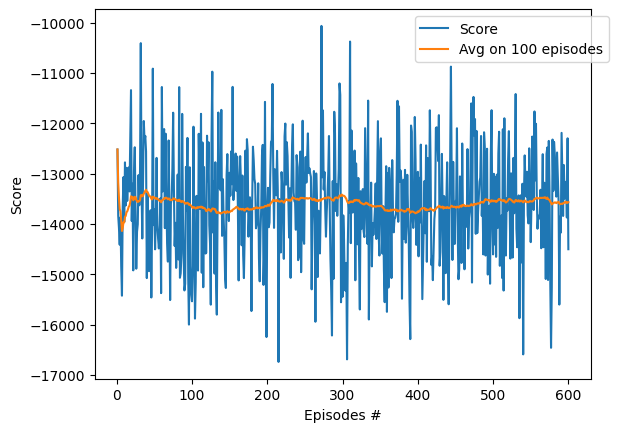

In [7]:
print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [8]:
#--------------- make_vec_envs ----------------
## we continue with the same model, model Policy uses MLPBase, but with new environment env_venv

device = torch.device("cpu")
print('device: ', device)

seed = 0 
num_processes=1

env_venv = make_vec_envs('Group24M4-v0', \
                    seed + 1000, num_processes,
                    None, None, False, device='cpu', allow_early_resets=False)

actor_nn = actor_nn.to(device)
critic_nn = critic_nn.to(device)

print('env_venv.observation_space.shape: ', env_venv.observation_space.shape, \
      ', len(obs_shape): ', len(env_venv.observation_space.shape))
print('env_venv.action_space: ',  env_venv.action_space, \
      ', action_space.shape[0]: ', env_venv.action_space.shape[0])


device:  cpu
env_venv.observation_space.shape:  (35,) , len(obs_shape):  1
env_venv.action_space:  Box(-1.0, 1.0, (4,), float32) , action_space.shape[0]:  4


### 5. Test and display training results

In [9]:
## No CUDA, only CPU
def play_VecEnv(env, actor_nn, critic_nn, num_episodes, recurrent_hidden_state_size):

    # for name, param in actor_nn.named_parameters():
    #     print(name, param)
        
    # for name, param in critic_nn.named_parameters():
    #     print(name, param)
        
    obs = env.reset()
    obs = torch.Tensor(obs)
    obs = obs.float()
    
    recurrent_hidden_states = torch.zeros(1, recurrent_hidden_state_size)
    
    masks = torch.ones(1, recurrent_hidden_state_size,dtype=torch.float32)
    
    scores_deque = deque(maxlen=100)

    render_func = get_render_func(env)
        
    for i_episode in range(1, num_episodes+1):     

        time_start = time.time()
        total_reward = np.zeros(num_processes)
        timestep = 0

        while True:
        
            with torch.no_grad():
                value, action, _, recurrent_hidden_states = \
                    actor_nn.act(obs, recurrent_hidden_states, masks, \
                    deterministic=False) # obs = state

            render_func()
            
            obs, reward, done, _ = env.step(action)
            obs = torch.Tensor(obs)
            obs = obs.float()

            reward = reward.detach().numpy()
            
            masks.fill_(0.0 if done else 1.0)
            
            total_reward += reward[0]

            timestep += 1
            
            if timestep + 1 == 1600: ##   envs.max_steps:
                break

        s = (int)(time.time() - time_start)
        
        scores_deque.append(total_reward[0])
        
        avg_score = np.mean(scores_deque)
                    
        print('Episode {} \tScore: {:.2f}, Avg.Score: {:.2f}, \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, total_reward[0], avg_score,  s//3600, s%3600//60, s%60))  
    
    env.close()

In [12]:
play_VecEnv(env=env_venv, actor_nn=actor_nn, critic_nn=critic_nn, num_episodes=5,recurrent_hidden_state_size=35)

Episode 1 	Score: -14900.46, Avg.Score: -14900.46, 	Time: 00:01:04
Episode 2 	Score: -13181.86, Avg.Score: -14041.16, 	Time: 00:01:04
Episode 3 	Score: -15803.81, Avg.Score: -14628.71, 	Time: 00:01:04
Episode 4 	Score: -16003.65, Avg.Score: -14972.45, 	Time: 00:01:04
Episode 5 	Score: -10971.30, Avg.Score: -14172.22, 	Time: 00:01:04


In [11]:
env_venv.close()
obs = env_venv.reset()
env_venv.close()